https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import random
import numpy as np

random.seed(34)
np.random.seed(34)

In [3]:
from utils import *

In [4]:
X_train, y_train = generate_dataset(directory='./TrainingData', MAX_LEN=170)

In [5]:
X_test, y_test = generate_dataset(directory='./TestingData', MAX_LEN=170)

In [6]:
X_train.shape

(120, 170, 33)

In [7]:
X_test.shape

(40, 170, 33)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## Hyperparameter Fine-tuning

In [13]:
best_model = None
best_history = None
best_acc = 0

learning_rates = [1e-4, 1e-3, 2e-3, 2.5e-3, 1e-2]
dropouts = [0.1, 0.2, 0.3, 0.35, 0.4, 0.5]
epochs = [20, 30, 40, 50, 60, 70]

results = pd.DataFrame(columns=['Learning Rate', 'Dropout', 'Epochs', 'Accuracy'])

for lr in learning_rates:
    for dp in dropouts:
        for ep in epochs:
            model = models.Sequential([
                layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                layers.MaxPooling1D(pool_size=2),
                layers.Conv1D(32, kernel_size=3, activation='relu'),
                layers.MaxPooling1D(pool_size=2),
                layers.Flatten(),
                layers.Dense(32, activation='relu', kernel_regularizer='l2'),
                layers.Dropout(dp),
                layers.Dense(1, activation='sigmoid')
            ])
            
            model.compile(optimizer=Adam(learning_rate=2e-3), loss='mean_squared_error', metrics=['accuracy'])

            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=16,
                validation_split=0.2,
                verbose=0
            )

            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print(f"Learning Rate: {lr}, Dropout: {dp}, Epochs: {ep}")
            print(f"Test Accuracy: {test_accuracy:.2f}")

            new_row = pd.DataFrame({
                'Learning Rate': [lr],
                'Dropout': [dp],
                'Epochs': [ep],
                'Accuracy': [test_accuracy]
            })
            results = pd.concat([results, new_row], ignore_index=True)

            if test_accuracy > best_acc:
                best_model = model
                best_history = history
                best_acc = test_accuracy

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7229 - loss: 0.2043
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 20
Test Accuracy: 0.73
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7125 - loss: 0.2199
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 30
Test Accuracy: 0.73
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6479 - loss: 0.2794
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 40
Test Accuracy: 0.68
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7125 - loss: 0.2498
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 50
Test Accuracy: 0.73
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7667 - loss: 0.1884
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 60
Test Accuracy: 0.77
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7229 - loss: 0.2094
Learning Rate: 0.0001, Dropout: 0.1, Epochs: 70
Test Accuracy: 0.73
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6792 - loss: 0.2293
Learning Rate: 0.0001, Dropout: 0.2, Epochs: 20
Test Accuracy: 0.68
2/2 ━━━━━━━━━━━━━━━━

In [14]:
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int) 

print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [15]:
def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

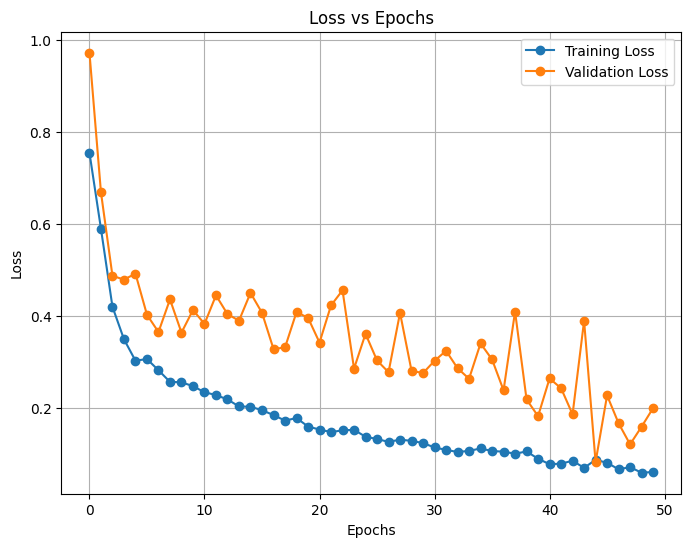

In [16]:
plot_training_history(best_history)

In [21]:
html_table = results.to_html(index=False, classes='table table-striped')
with open("table.html", "w") as f:
    f.write(html_table)